Long-range genomic language models identify extensive chimera artifacts in Nanopore direct RNA sequencing
Figure 1A, schematic of LLM

Figure 1B, simulation (internal and terminal), CNN, CNN+transformer, HyenaDNA

Figure 1C, real data VCaP002/VCaP004, detected chimeric reads when applying Dorado and Deepchopper, validation of chimeric read by direct cDNA, (Bar plot, Dorado trim, Dorado w/o trim, Deepchopper), 

Explain the coverage difference between true events and artifacts, we expect true events have higher coverage than false positive events, at least in RNA004 and PromethION data.

Figure 1D, E, F: BLAT, quality and PolyA motif for false positive chimeric artifacts. (possible in supplementary)

Figure 1G: other platforms, such as ONT cDNA(direct or PCR), R2C2, CapTrap etc. Testing this using H1 and WTC11 from ENCODE. Test if other platforms have less chimeric artifacts predicted by DeepChopper and reduced artifact reads almost cannot be validated by other platforms.
(https://www.encodeproject.org/matrix/?type=Experiment&control_type!=*&assay_term_name=long+read+RNA-seq&status=released)

Figure 2: A,B,C 
distribution of false positives across chr, 

gene expression and size distribution for those with artifacts. 
Gene GO enrichment suggests Ribosome and ChrM genes are frequently involved.

~~Figure 1J, gene rescue, including the chrM genes.~~

Figure 2D, gene fusion due to chimeric artifacts, highlighted by IGV and current signals, for example open pore signal, adapter feature signals!
Figure 2E: Count the percentage of Deepchopper splitted reads accounting for original chimeric reads and unmapped reads. Count how many of the unmapped reads can be remapped after deepchopper split. 

Could the relative (and/or absolute) coverage increase of genes ranked by these ratios or counts?

Figure 1 Supplementary
Terminal adapter quality, soft-clipping mapping comparison


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import seaborn as sns
import json

In [3]:
import pandas as pd
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [12]:
from matplotlib import rcParams

# Set global font properties to Arial
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Arial",
        "pdf.fonttype": 42,  # Embed fonts as Type 3 fonts for compatibility
        "ps.fonttype": 42,
        "text.usetex": False,
        "svg.fonttype": "none",
    }
)

rcParams.update(
    {
        "font.size": 24,  # Set a default font size
        "legend.fontsize": 16,
        "legend.handlelength": 2,
        "axes.linewidth": 2,
    }
)

plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.labelsize"] = 20

In [5]:
# % colors
c1 = [i / 255 for i in (255, 200, 200)]
c2 = [i / 255 for i in (150, 220, 150)]
c3 = [i / 255 for i in (172, 188, 63)]

In [6]:
# https://mp.weixin.qq.com/s/7Q0bY7aj2Us6yOMy7ym6TA

d1 = "#BF1D2D"
d2 = "#262626"
d3 = "#293890"

In [7]:
e1 = "#2F2D54"
e2 = "#9193B4"
e3 = "#BD9AAD"
e4 = "#E8D2B3"

# F1B  Simulation Result 

In [90]:


# CNN 12 0000
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃        Test metric        ┃       DataLoader 0        ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
# │          test/f1          │    0.9973070621490479     │
# │         test/loss         │   0.0006464940961450338   │
# │      test/precision       │    0.9969919919967651     │
# │        test/recall        │    0.9976223707199097     │
# └───────────────────────────┴───────────────────────────┘

# Hyena 120 0000
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃        Test metric        ┃       DataLoader 0        ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
# │          test/f1          │    0.9930047988891602     │
# │         test/loss         │   0.0018698567291721702   │
# │      test/precision       │    0.9916011691093445     │
# │        test/recall        │    0.9944124817848206     │
# └───────────────────────────┴───────────────────────────┘

# CNN 120 0000
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃        Test metric        ┃       DataLoader 0        ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
# │          test/f1          │    0.9906293749809265     │
# │         test/loss         │   0.0032503148540854454   │
# │      test/precision       │    0.9909157156944275     │
# │        test/recall        │    0.9903432130813599     │
# └───────────────────────────┴───────────────────────────┘


def simulation_plot(cl1, cl2, figsize=(6, 6), alpha=0.7, xlim=(0.8, 1), ylim=(0.8, 1)):
    cnn_name = "CNN"
    dc_name = "DeepChopper"

    data = {
        cnn_name: [0.9909157156944275, 0.9903432130813599],
        dc_name: [0.9916011691093445, 0.9944124817848206],
    }

    # Create a figure and axis
    _, ax = plt.subplots(figsize=figsize)

    # Define the F1 scores to plot
    f_scores = [0.2, 0.4, 0.6, 0.8, 0.9]

    # Initialize lists for lines and labels
    lines, labels = [], []

    # Plot F1 score iso-lines
    for f_score in f_scores:
        x = np.linspace(0.01, 1, 500)
        y = f_score * x / (2 * x - f_score)

        # Ensure y values are within [0, 1] range
        valid = (y >= 0) & (y <= 1)
        x = x[valid]
        y = y[valid]
        (l,) = plt.plot(x, y, color="gray", alpha=0.2, linewidth=3)

        # Add F1 score annotations
        plt.annotate(
            f"f1={f_score:0.1f}", xy=(0.9, f_score * 0.9 / (2 * 0.9 - f_score) + 0.02)
        )

    cnn_handle = plt.scatter(
        *data[cnn_name], c=cl1, s=120, label=cnn_name, alpha=alpha, edgecolors="none"
    )
    deepchopper_handle = plt.scatter(
        *data[dc_name], c=cl2, s=120, label=dc_name, alpha=alpha, edgecolors="none"
    )

    # # Add the scatter plots to handles
    handles = [cnn_handle, deepchopper_handle, l]
    labels = [cnn_name, dc_name, "Iso-f1 Curves"]
    plt.legend(handles=handles, labels=labels, loc="upper left")

    # Set the axis limits
    plt.xlim(xlim)
    plt.ylim(ylim)

    sns.despine(offset=10, trim=True)
    # Label the plot
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

    plt.tight_layout()
    plt.savefig("simulation_pr.pdf", dpi=300)

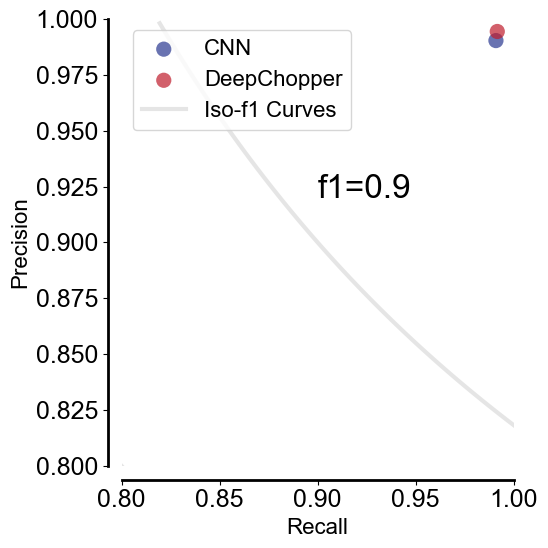

In [92]:
simulation_plot(d3, d1)

# F1C Bar PLot for Chemeric Read compare

In [10]:
type_names = ["Dorado with Trim", "Dorado w/o Trim", "DC"]

vcap002_data = {
    type_names[0]: [107266, 6228],
    type_names[1]: [107304, 6228],
    type_names[2]: [9844, 4664],
}

vcap004_data = {
    type_names[0]: [29144, 7165],
    type_names[1]: [29542, 7119],
    type_names[2]: [23045, 7027], 
}


def prepare_data(data):
    data_with_validated = {
        "value": list(
            chain.from_iterable(
                [[data[t][0] - data[t][1], data[t][1]] for t in type_names]
            )
        ),
        "data type": list(chain.from_iterable([[i] * 2 for i in type_names])),
        "type": ["Unvalidated", "Validated"] * len(type_names),
    }
    data_df = pd.DataFrame(data_with_validated)
    return data_df

In [12]:
data_df = prepare_data(vcap002_data)
vcap004_data_df = prepare_data(vcap004_data)
# wtc11_data_df = prepare_data(wtc11_data)

In [13]:
data_df

,value,data type,type
0,101038,Dorado with Trim,Unvalidated
1,6228,Dorado with Trim,Validated
2,101076,Dorado w/o Trim,Unvalidated
3,6228,Dorado w/o Trim,Validated
4,5180,DC,Unvalidated
5,4664,DC,Validated


Text(0, 0.5, 'Count')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Data  Type')

Text(0.5, 0, 'Data  Type')

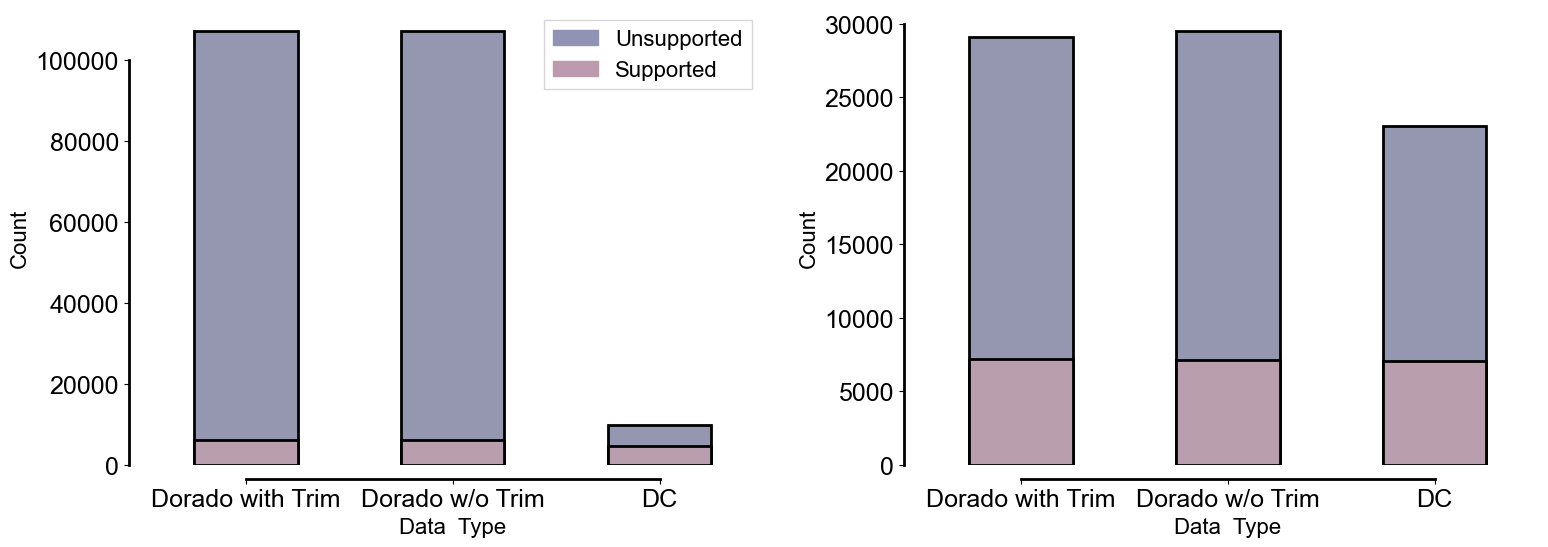

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
axs = axs.flatten()

bar_width = 0.5

bar1 = sns.barplot(
    data=data_df.groupby("data type")["value"].sum().reset_index(),
    x="data type",
    y="value",
    order=type_names,
    color=e2,
    edgecolor="k",
    linewidth=2,
    width=bar_width,
    ax=axs[0],
)
bar2 = sns.barplot(
    data=data_df.query("type == 'Validated'"),
    x="data type",
    y="value",
    order=type_names,
    estimator=sum,
    color=e3,
    edgecolor="k",
    linewidth=2,
    width=bar_width,
    ax=axs[0],
)


bar3 = sns.barplot(
    data=vcap004_data_df.groupby("data type")["value"].sum().reset_index(),
    x="data type",
    y="value",
    order=type_names,
    color=e2,
    edgecolor="k",
    linewidth=2,
    width=bar_width,
    ax=axs[1],
)
bar4 = sns.barplot(
    data=vcap004_data_df.query("type == 'Validated'"),
    x="data type",
    y="value",
    order=type_names,
    estimator=sum,
    color=e3,
    edgecolor="k",
    linewidth=2,
    width=bar_width,
    ax=axs[1],
)


# add legend
top_bar = mpatches.Patch(color=e2, label="Unsupported")
bottom_bar = mpatches.Patch(color=e3, label="Supported")
axs[0].legend(handles=[top_bar, bottom_bar], fancybox=False)

sns.despine(offset=10, trim=True)

axs[0].set_ylabel("Count")
axs[1].set_ylabel("Count")

axs[0].set_xlabel("Data  Type")
axs[1].set_xlabel("Data  Type")

plt.tight_layout()
plt.savefig("bar_plot_chemeric_read_cmp.pdf", dpi=300)

In [8]:
# wtc11  and other platform  plot

type_names_other_platform = ["Dorado with Trim", "DC"]

vcap_002_event_data = {type_names_other_platform[0]: [107266, 6228], type_names_other_platform[1]: [9844, 4664]}
vcap_004_event_data = {type_names_other_platform[0]: [10708, 2917], type_names_other_platform[1]: [5028, 1858]}


wtc11_data = {
    "ONT PCR cDNA": {type_names_other_platform[0]: [12987, 4765], type_names_other_platform[1]: [5903, 3904]},
    "ONT CapTrap": {type_names_other_platform[0]: [12987, 3972], type_names_other_platform[1]: [5903, 3343]},
    "ONT R2C2": {type_names_other_platform[0]: [12987, 4023], type_names_other_platform[1]: [5903, 3913]},
    "PB cDNA": {type_names_other_platform[0]: [12987, 3970], type_names_other_platform[1]: [5903, 3873]},
    "PB CapTrap": {type_names_other_platform[0]: [12987, 3410], type_names_other_platform[1]: [5903, 3027]}
    }

def prepare_data_other_platform(data, type_names):
    data_with_validated = {
        "value": list(
            chain.from_iterable(
                [[data[t][0] - data[t][1], data[t][1]] for t in type_names]
            )
        ),
        "data type": list(chain.from_iterable([[i] * 2 for i in type_names])),
        "type": ["Unvalidated", "Validated"] * len(type_names),
    }
    data_df = pd.DataFrame(data_with_validated)
    return data_df


def plot_other_platform(data, type_names, figsize=(20, 10)):

    fig, axs = plt.subplots(2, 3, figsize=figsize, sharey=False)
    axs  = axs.flatten()
    bar_width = 0.3

    # add legend
    top_bar = mpatches.Patch(color=e2, label="Unsupported")
    bottom_bar = mpatches.Patch(color=e3, label="Supported")
    
    ax_id = 0
    for dtype, values in data.items():
        ax = axs[ax_id]
        dtype_df = prepare_data_other_platform(values, type_names)

        bar1 = sns.barplot(
            data=dtype_df.groupby("data type")["value"].sum().reset_index(),
            x="data type",
            y="value",
            order=type_names,
            color=e2,
            edgecolor="k",
            linewidth=2,
            width=bar_width,
        ax=ax,
        )
        bar2 = sns.barplot(
            data=dtype_df.query("type == 'Validated'"),
            x="data type",
            y="value",
            order=type_names,
            estimator=sum,
            color=e3,
            edgecolor="k",
            linewidth=2,
            width=bar_width,
            ax=ax,
        )
        ax.legend(handles=[top_bar, bottom_bar], fancybox=False)

        ax.set_ylabel("Count")
        ax.set_xlabel("Data  Type")
        ax.set_title(dtype)
     
        ax_id +=1

    # remove last axis 
    axs[-1].axis("off")

    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.savefig("wtc11_bar_plot_chemeric_read_cmp.pdf", dpi=300)

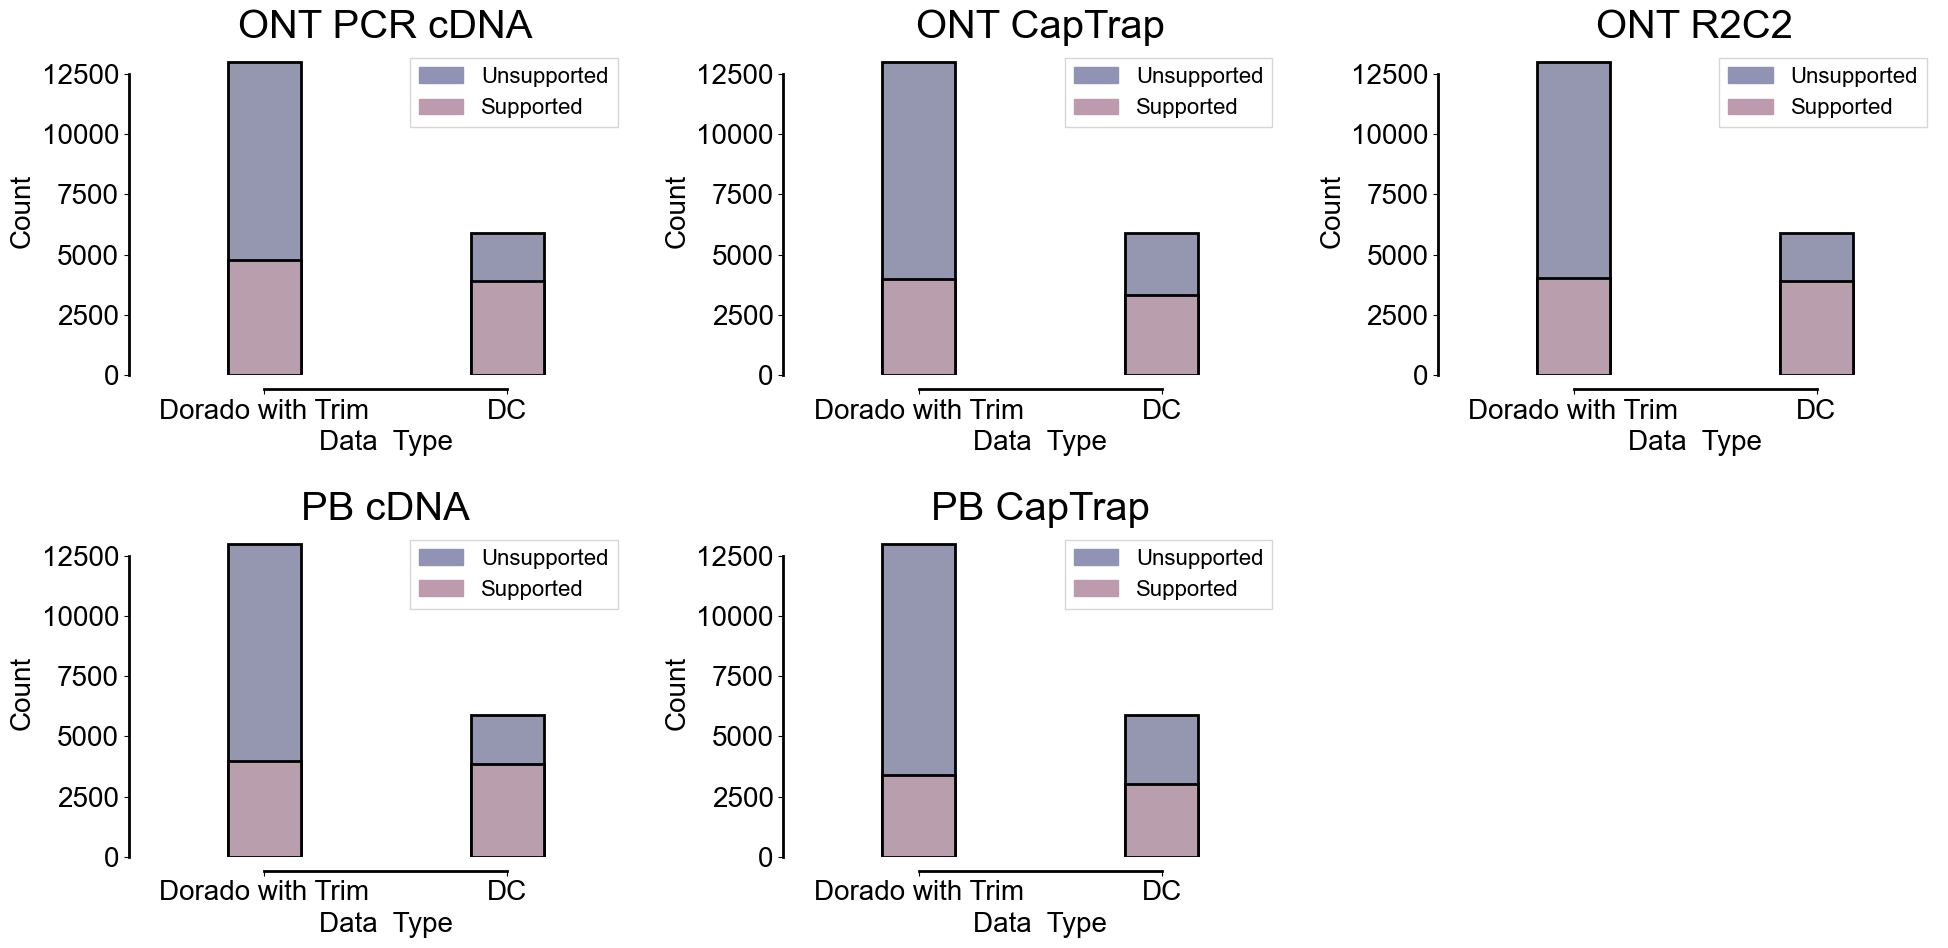

In [13]:
plot_other_platform(wtc11_data, type_names_other_platform)

# F1 Bar Plot for Chimeric Read Group Event

In [2]:
def plot_event(data, type_names, figsize=(8, 6), figname="group_chimeric_bar_plot.pdf"):
    fig, ax = plt.subplots(figsize=figsize)

    dtype_df = prepare_data_other_platform(data, type_names)

    bar_width = 0.3
    
    # add legend
    top_bar = mpatches.Patch(color=e2, label="Unsupported")
    bottom_bar = mpatches.Patch(color=e3, label="Supported")

    bar1 = sns.barplot(
        data=dtype_df.groupby("data type")["value"].sum().reset_index(),
        x="data type",
        y="value",
        order=type_names,
        color=e2,
        edgecolor="k",
        linewidth=2,
        width=bar_width,
    ax=ax,
    )
    bar2 = sns.barplot(
        data=dtype_df.query("type == 'Validated'"),
        x="data type",
        y="value",
        order=type_names,
        estimator=sum,
        color=e3,
        edgecolor="k",
        linewidth=2,
        width=bar_width,
        ax=ax,
    )
    ax.legend(handles=[top_bar, bottom_bar], fancybox=False)

    ax.set_ylabel("Count")
    ax.set_xlabel("Data  Type")

    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.savefig(figname, dpi=300)

In [13]:
type_names_other_platform = ["Dorado with Trim", "DC"]

vcap_002_event_data = {type_names_other_platform[0]: [79015, 5740], type_names_other_platform[1]: [4947, 2509]}

vcap_004_event_data = {type_names_other_platform[0]: [10708, 2917], type_names_other_platform[1]: [5028, 1858]}

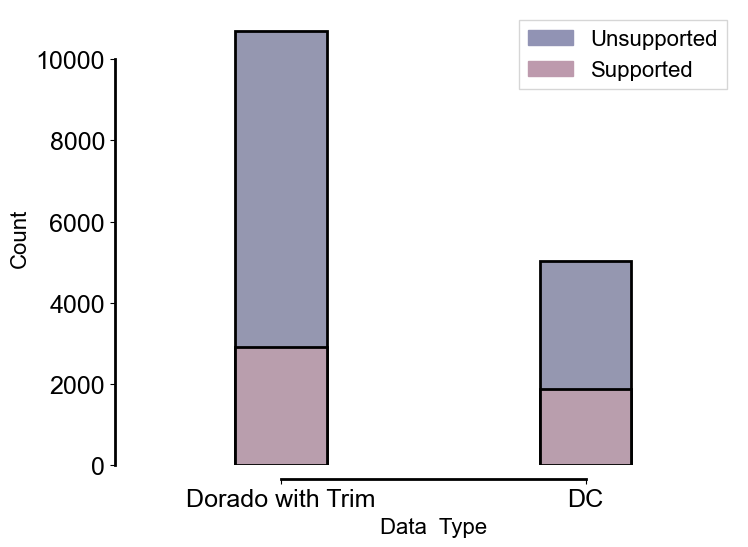

In [24]:
plot_event(vcap_004_event_data, type_names_other_platform, figname="vcap004_group_chimeric_bar_plot.pdf")

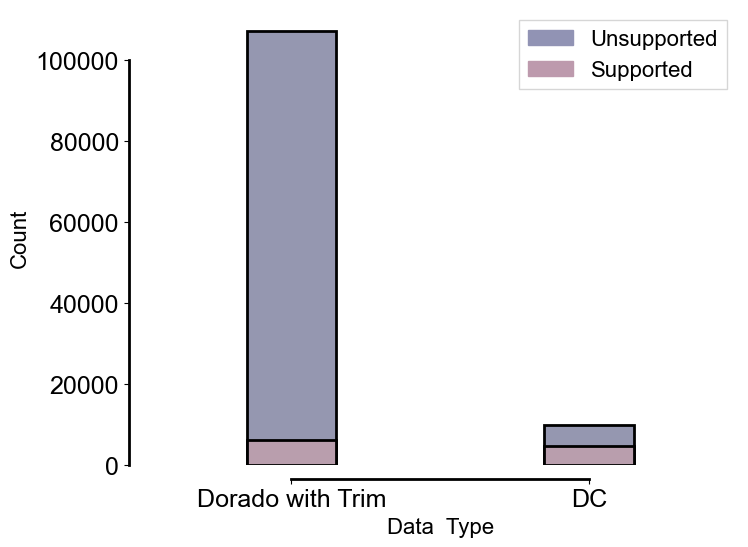

In [16]:
plot_event(vcap_002_event_data, type_names_other_platform, figname="vcap002_group_chimeric_bar_plot.pdf")

# F1D BLAT for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [17]:
import json

In [18]:
# load data
plot_data_vcap_002 = json.load(open("data/internal_prediction_seq_blat_top1_indentities.json"))
plot_data_vcap_004 = json.load(
    open("data/fp_vcap_004_hyena_all_predicts_blat_identities.json")
)

In [19]:
len(plot_data_vcap_002)

98807

In [114]:
len(plot_data_vcap_004)

6185

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

Text(0.5, 0, 'BLAT Indentity')

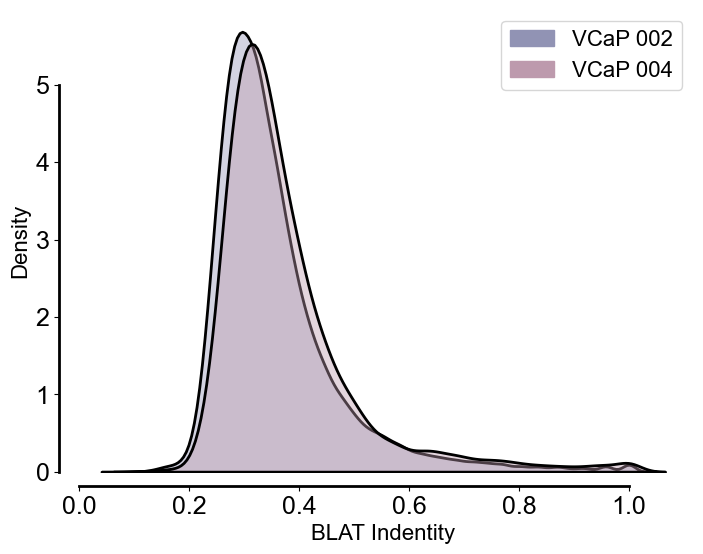

In [62]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=plot_data_vcap_002, fill=True, color=e2, edgecolor="k", linewidth=2, alpha=0.4)
sns.kdeplot(
    data=plot_data_vcap_004, fill=True, color=e3, edgecolor="k", linewidth=2, alpha=0.4
)

left_bar = mpatches.Patch(color=e2, label="VCaP 002")
right_bar = mpatches.Patch(color=e3, label="VCaP 004")
plt.legend(handles=[left_bar, right_bar], loc="upper right")

sns.despine(offset=10, trim=True)
plt.xlabel("BLAT Indentity")
# plt.ylabel("Density")
plt.savefig(
    "blat_for_fp_internal_prediction_cmp_with_dorado.pdf", bbox_inches="tight", dpi=300
)

In [21]:
def box_distribution_plot(data, figsize=(8, 6), figname="box_distri_plot.pdf"):
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(data=data, ax=ax, palette=[e2, e3])
    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.savefig(figname, dpi=300)

<Axes: >

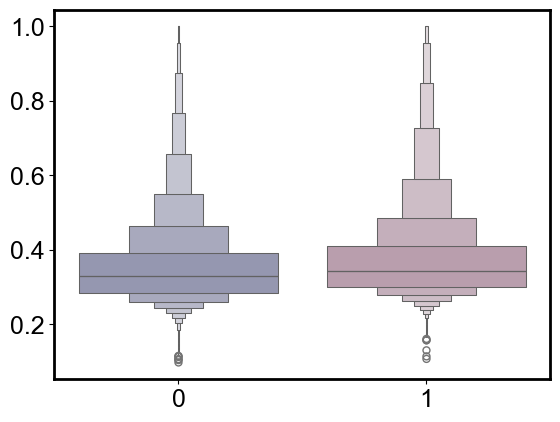

In [22]:
sns.boxenplot(data=[plot_data_vcap_002, plot_data_vcap_004], palette=[e2, e3])

In [104]:
def distributio_plot(data, figsize=(8, 6), color=e2, alpha=1, file_name=""):
    plt.figure(figsize=(7, 6))
    sns.kdeplot(data=data, fill=True, color=color, edgecolor="k", linewidth=2, alpha=1)

    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.xlabel("BLAT Indentity")
    plt.savefig(f"identity_distribution_{file_name}.pdf", dpi=300)

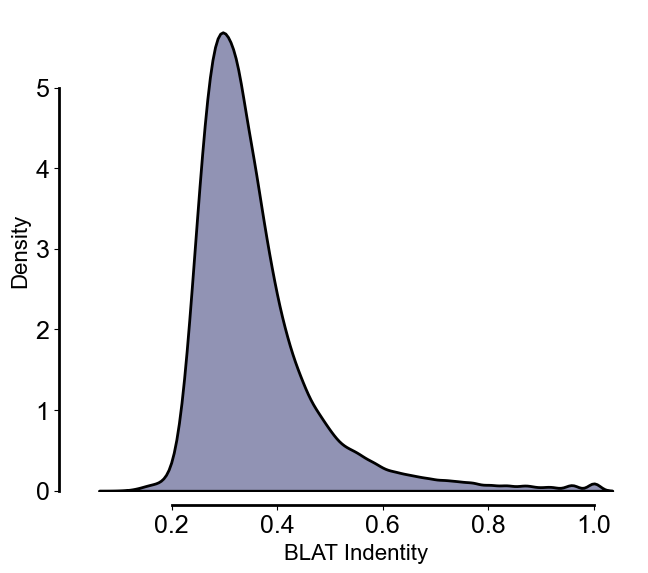

In [105]:
distributio_plot(plot_data_vcap_002, color=e2, file_name="vcap_002")

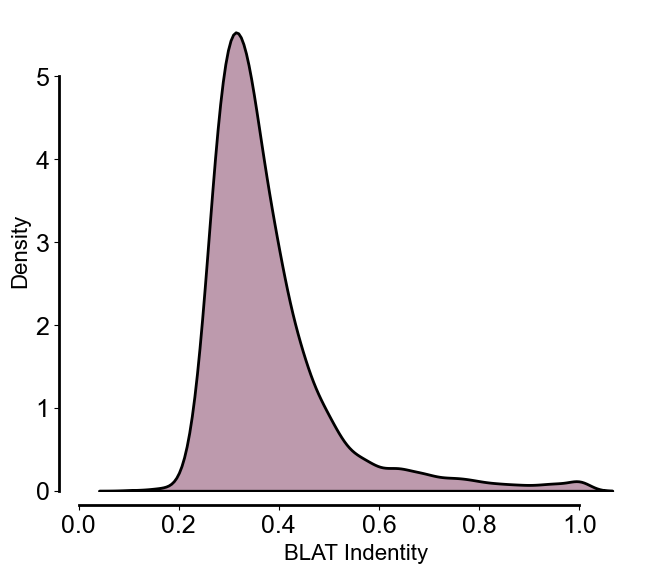

In [106]:
distributio_plot(plot_data_vcap_004, color=e3, file_name="vcap_004")

# F1E Base Quals for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [32]:
import json

In [33]:
def plot_qual(file_path):
    from needletail import parse_fastx_file

    quals = []
    for record in parse_fastx_file(file_path):
        current_quals = [ord(i) - 33 for i in list(record.qual)]
        quals.append(sum(current_quals) / len(current_quals))
    return quals

In [34]:
# load data
plot_data_remove_seq_base_quals_vcap002 = [
    i - 33 for i in json.load(open("data/internal_prediction_seq_base_quals.json"))
]
# load data
# plot_qual_left_seq_data = plot_qual("./data/fp_dorado_hyena_vcap_002.fq.gz")

In [26]:
# len(plot_qual_left_seq_data)

In [36]:
len(plot_data_remove_seq_base_quals_vcap002)

146580

In [28]:
plot_data_remove_seq_base_quals_vcap004 = [
    i - 33 for i in json.load(open("data/fp_vcap_004_hyena_predicts_base_quals.json"))
]
# vcap_plot_qual_left_seq_data = plot_qual("./data/fp_dorado_hyena_vcap_004.fq.gz")

In [113]:
len(plot_data_remove_seq_base_quals_vcap004)

11143

In [30]:
# len(vcap_004_plot_data)

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

Text(0.5, 0, 'Base Qual')

Text(0.5, 0, 'Base Qual')

Text(0, 0.5, 'Density')

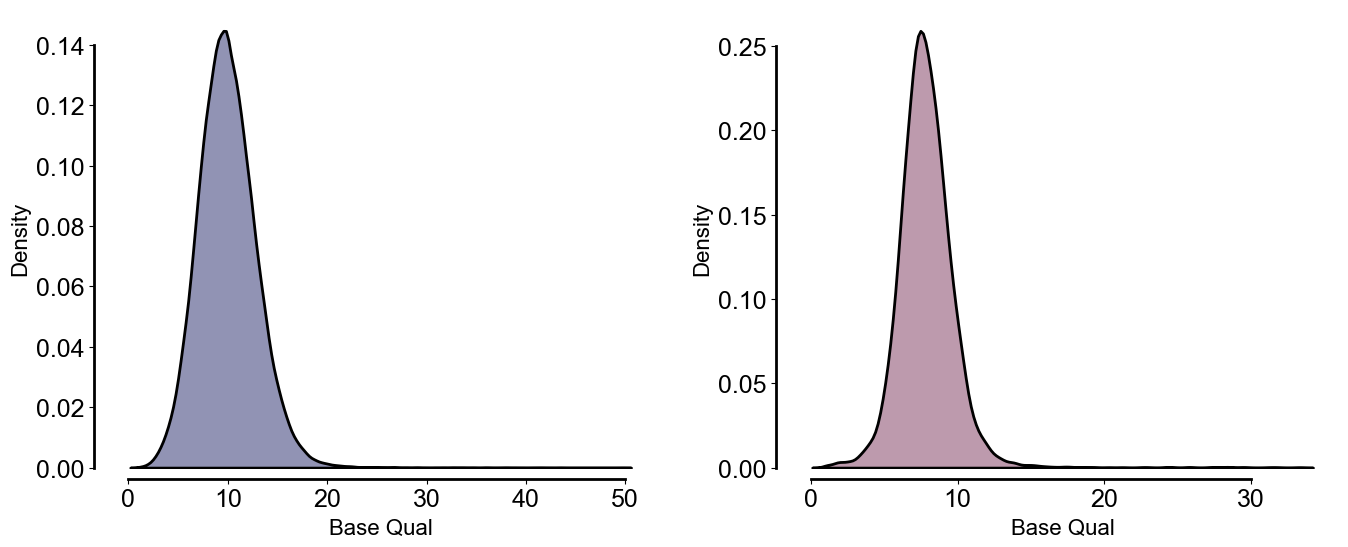

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
axs = axs.flatten()

sns.kdeplot(data=plot_data_remove_seq_base_quals_vcap002, fill=True, color=e2, edgecolor="k", linewidth=2, alpha=1, ax=axs[0])

# sns.kdeplot(
#     data=plot_qual_left_seq_data,
#     fill=True,
#     color=e3,
#     edgecolor="k",
#     linewidth=2,
#     ax=axs[0],
# )

sns.kdeplot(
    data=plot_data_remove_seq_base_quals_vcap004, fill=True, color=e3, edgecolor="k", linewidth=2, alpha=1, ax=axs[1]
)

# sns.kdeplot(
#     data=vcap_plot_qual_left_seq_data,
#     fill=True,
#     color=e3,
#     edgecolor="k",
#     linewidth=2,
#     ax=axs[1],
# )

# left_bar = mpatches.Patch(color=e2, label="Removed Sequence")
# right_bar = mpatches.Patch(color=e3, label="Retained Sequence")
# axs[1].legend(handles=[left_bar, right_bar], loc="best")

sns.despine(offset=8, trim=True)

axs[0].set_xlabel("Base Qual")
axs[1].set_xlabel("Base Qual")
plt.ylabel("Density")


plt.tight_layout()

# fig.subplots_adjust(wspace=0.1)

plt.savefig(
    "base_quals_for_fp_internal_prediction_cmp_with_dorado.pdf",
    bbox_inches="tight",
    dpi=300,
)

### F1 Boxplot of BLAT and Qual for PolyA motif for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [100]:
def plot_box_for_base_qual_and_blat(base_qual, blat_identity, figsize=(8, 6), c1=d1, c2=d3, width=0.4, plot_type="violinplot", figname="base_qual_blat_identity_box_plot.pdf"):
    # Creating a DataFrame for the plot
    t1 = "Base Quality"
    t2 = "BLAT Identity"

    df1 = pd.DataFrame({
        'Score': base_qual,
        'Type': t1
    })

    df2 = pd.DataFrame({
        'Score': blat_identity,
        'Type': t2
    })

    # Concatenating the dataframes
    df = pd.concat([df1, df2])

    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()

    getattr(sns, plot_type)(x='Type', y='Score', data=df[df['Type'] == t1], ax=ax1, color=c1, width=width, fill=True)
    ax1.set_ylabel(t1)

    # Plotting the boxenplot for the identity scores on the right y-axis
    getattr(sns, plot_type)(x='Type', y='Score', data=df[df['Type'] == t2], ax=ax2, color=c2, width=width, fill=True)
    ax2.set_ylabel(t2)

    # ax2.spines['right'].set_color(d3)
    # ax2.yaxis.label.set_color(d3)
    # ax2.tick_params(axis='y', colors=d3)

    # Ensuring the x-axis categories do not overlap
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels([t1, t2])
    
    # add offset 
    sns.despine(offset=10, trim=True, right=False)

    # Adjusting the plot to avoid overlapping of labels
    fig.tight_layout()
    plt.savefig(figname,   bbox_inches="tight", dpi=300)

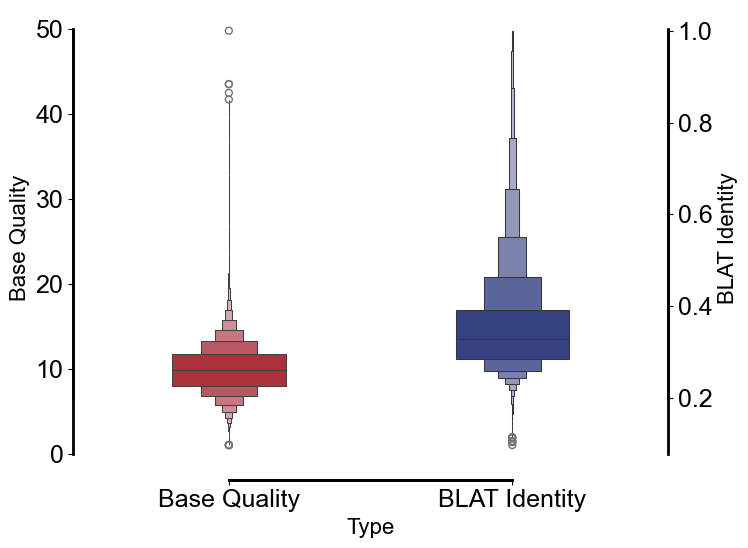

In [101]:
plot_box_for_base_qual_and_blat(plot_data_remove_seq_base_quals_vcap002, plot_data_vcap_002, plot_type="boxenplot",figname="vcap002_base_qual_and_blat_box_plot.pdf")

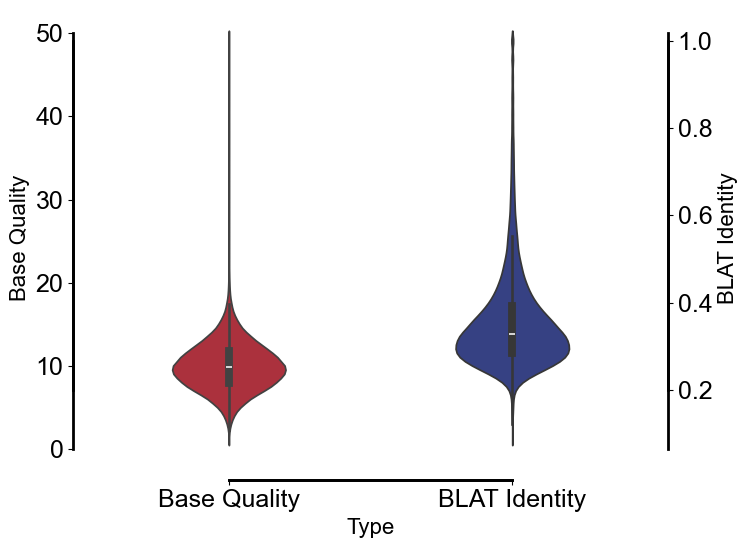

In [102]:
plot_box_for_base_qual_and_blat(plot_data_remove_seq_base_quals_vcap002, plot_data_vcap_002, plot_type="violinplot",figname="vcap002_base_qual_and_blat_violinplot_plot.pdf")

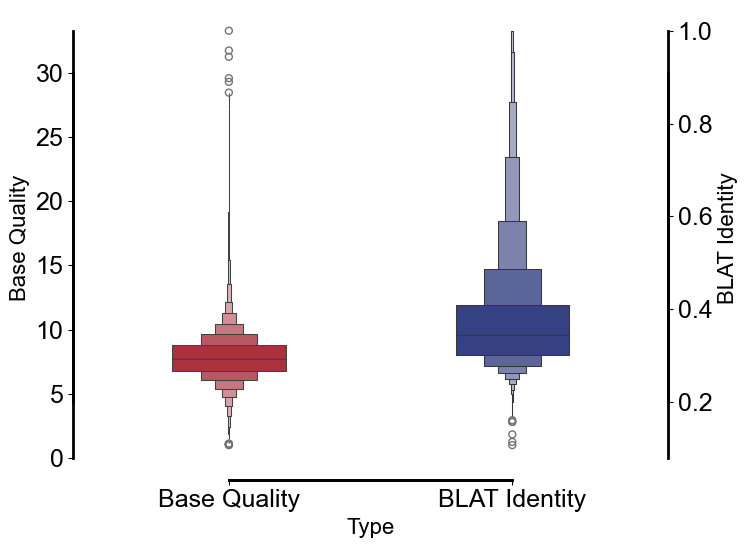

In [115]:
plot_box_for_base_qual_and_blat(plot_data_remove_seq_base_quals_vcap004, plot_data_vcap_004, plot_type="boxenplot",figname="vcap004_base_qual_and_blat_box_plot.pdf")

# F1 Histogram for Count of left seq

In [103]:
import json

In [128]:
left_seq_counts = json.load(open("data/vcap_002_left_seq_counts.json"))

In [110]:
left_seq_counts_larger_than_1 = [v for k,v in left_seq_counts.items() if v > 1]

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 0, 'The Number of Intervals Per Predict')

Text(0, 0.5, 'Count (Log Scale)')

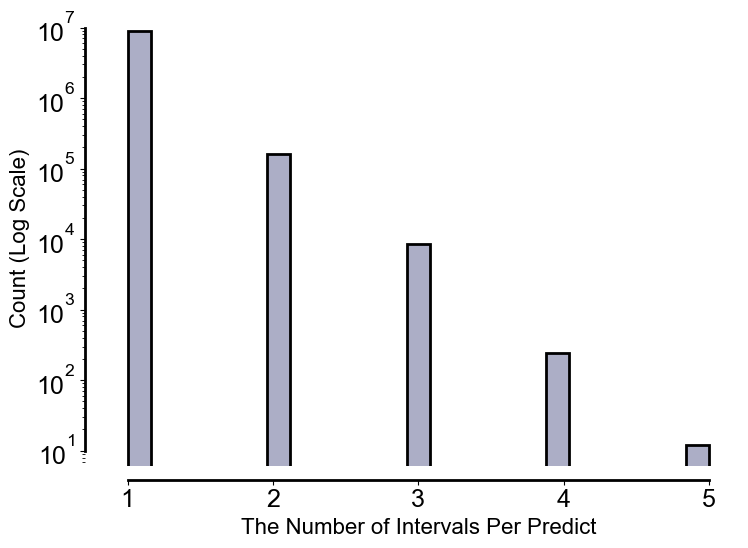

In [130]:
plt.figure(figsize=(8,6))

sns.histplot(list(left_seq_counts.values()), kde=False, color=e2, edgecolor="k", linewidth=2)
plt.yscale('log')


plt.xlabel("The Number of Intervals Per Predict")
plt.ylabel("Count (Log Scale)")

sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("count_of_vcap_002_left_seq_per_read_all.pdf", dpi=300)

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 0, 'The Number of Intervals Per Predict')

Text(0, 0.5, 'Count (Log Scale)')

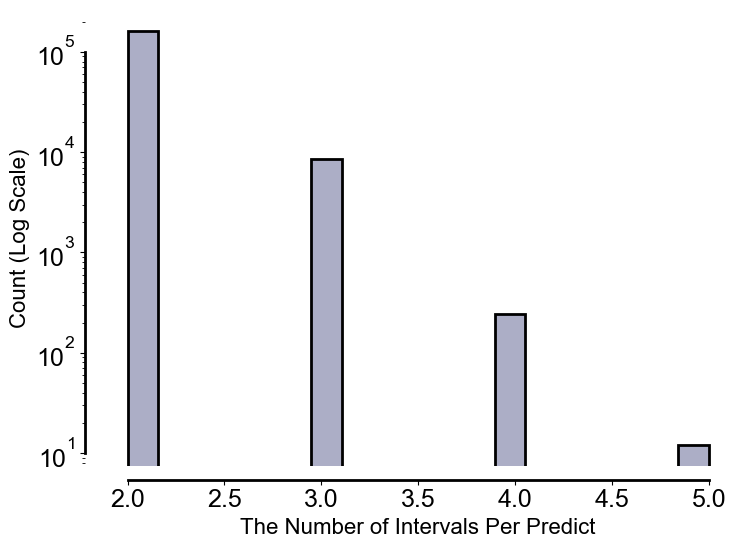

In [112]:
plt.figure(figsize=(8,6))

sns.histplot(left_seq_counts_larger_than_1, kde=False, color=e2, edgecolor="k", linewidth=2)
# sns.kdeplot(stats.number_smooth_predicts_with_chop(), fill=True, color=e1, edgecolor="k", linewidth=2)

plt.yscale('log')
# plt.xticks(range(0, max_x, 1))

plt.xlabel("The Number of Intervals Per Predict")
plt.ylabel("Count (Log Scale)")

sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("count_of_vcap_002_left_seq_per_read.pdf", dpi=300)

# F2A Gene Size Distribution for FP

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

def distribution_plot_f2a(data1, data2, figure_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot histogram
    sns.histplot(data1, kde=False, color=e1, label="All genes", ax=ax, binwidth=500)
    sns.histplot(data2, kde=False, color=e3, label="Target genes", ax=ax, binwidth=500)

    # Set labels and title
    ax.set_xlabel("Gene effective size")
    ax.set_ylabel("Frequency")
    ax.set_title("")

    ax.set_xlim(0, 20000)
    ax.set_ylim(0, 20000)
    #ax.set_xscale('log')

    # Add legend
    ax.legend()

    sns.despine(offset=0, trim=True)

    fig.tight_layout()

    fig.savefig(
        f"{figure_name}",
        dpi=300,
        facecolor="w",
        edgecolor="w",
        bbox_inches="tight",
    )
    # plt.close()

def data_preparation_f2a(all_file, target_file, col_name):
    all_genes = pd.read_csv(all_file, sep="\t", index_col=0)
    target_genes = pd.read_csv(target_file, sep="\t", index_col=0)
    all_data = list(all_genes[col_name])
    target_data = list(target_genes[col_name])
    return all_data, target_data


def f2a_plot(all_file, target_file, col_name, figure_name):
    all_data, target_data = data_preparation_f2a(all_file, target_file, col_name)
    distribution_plot_f2a(all_data, target_data, figure_name)

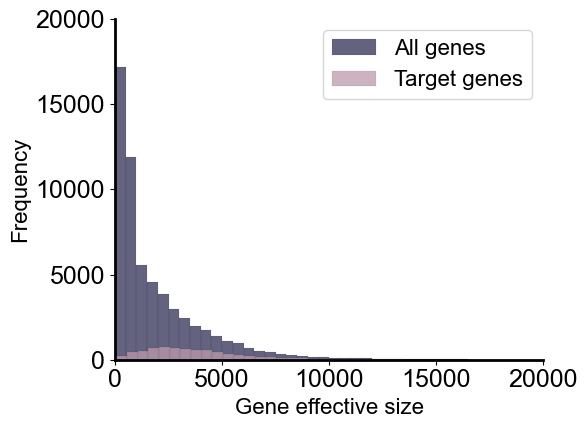

In [140]:
f2a_plot("data/gene_size.txt", "data/FP_exp.gene_size.txt", "maximum_effective_size", "gene_effective_size.pdf")

# F2B Gene Expression for FP

In [145]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import ranksums,wilcoxon,ttest_ind,mannwhitneyu,pearsonr,spearmanr,f_oneway,kruskal


def box_plot(data, figure_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot histogram
    sns.boxplot(x='group', y='exp', width=0.3, data=data, ax=ax, fill=False, whis=100000, showcaps=False)

    # Set labels and title
    # ax.set_xlabel("Gene effective size")
    ax.set_xlabel("")
    ax.set_ylabel("Gene expression level")
    ax.set_title("")

    #ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax.minorticks_off()
    # ax.set_xlim(0, 20000)
    ax.set_yscale('log')

    # Add legend
    # ax.legend()

    sns.despine(trim=True, left=False)
    fig.tight_layout(w_pad=1.1)
    fig.savefig(
        f"{figure_name}",
        dpi=300,
        facecolor="w",
        edgecolor="w",
        bbox_inches="tight",
    )


def data_preparation_f2b(all_file, target_file, col_name):
    all_genes = pd.read_csv(all_file, sep="\t", index_col=0)
    target_genes = pd.read_csv(target_file, sep="\t", index_col=0)
    all_data = list(all_genes[col_name])
    target_data = list(target_genes[col_name])

    data = pd.DataFrame(
        {
            "exp": np.concatenate([all_data, target_data]),
            "group": ["all_genes"] * len(all_data)
            + ["target_genes"] * len(target_data),
        }
    )
    all_exp = data[data["group"] == "all_genes"]["exp"]
    target_exp = data[data["group"] == "target_genes"]["exp"]

    print(mannwhitneyu(target_exp, all_exp, alternative="greater"))

    return data


def f2b_boxplot(all_file, target_file, col_name, figure_name):
    data = data_preparation_f2b(all_file, target_file, col_name)
    box_plot(data, figure_name)


MannwhitneyuResult(statistic=104581185.5, pvalue=0.0)


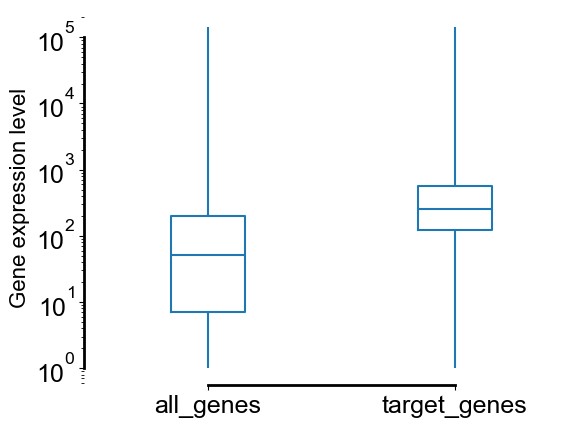

In [146]:
f2b_boxplot("data/dorado.gene_exp.txt", "data/FP_exp.gene_exp.txt", "exp_count", "gene_exp.pdf")

# FS2A distribution of false positives across chr

## Vcap 002  

In [ ]:
# [2024-07-17T15:42:11Z INFO  internal] Total number of reads: 175094
# [2024-07-17T15:42:11Z INFO  internal] Number of reads with SA tag: 869
# [2024-07-17T15:42:11Z INFO  internal] Number of reads without SA tag: 174225
# [2024-07-17T15:42:11Z INFO  internal] Summary saved to sa_summary.json
# [2024-07-17T15:42:11Z INFO  internal] elapsed time: 666.45ms

In [1]:
import pysam
import json

In [19]:
samfile  = pysam.AlignmentFile("data/fp_dorado_hyena_vcap_002.bam", "rb")

# len([1 for read in samfile.fetch() if read.is_mapped and not read.is_secondary and not read.is_supplementary])

# len([1 for read in samfile.fetch() if not read.is_mapped])

# for read in samfile.fetch():
#     if read.is_unmapped:
#         print(read)

In [28]:
# read_ids = [read.query_name for read in samfile.fetch()]
for read in samfile.fetch():
    if read.query_name == "a08a11cf-887d-4279-8724-26fafa1abcf5":
        print(read.reference_name, read.mapping_quality, read.is_mapped)
        if read.has_tag("SA") and not read.is_secondary and not read.is_supplementary:
            print(read.get_tag("SA"))
        # print(read)

chr10 38 True
chr11 60 True
chr6 0 True
chr6 0 True
chr8 60 True
chr11,46428626,-,82S506M21D941S,60,97;chr10,124490384,-,390S297M13240D842S,38,83;


In [29]:
vcap002_sa_tag_summary_path = "data/fp_dorado_hyena_vcap_002_do_sa_summary.json"
vcap002_sa_tag_summary = json.load(open(vcap002_sa_tag_summary_path))

In [30]:
len(vcap002_sa_tag_summary)

88164

In [35]:
vcap002_sa_tag_summary

{'9b31769e-5294-409f-9347-272ecf7917dd': ['chr5:181236937', 'chr19:36115547'],
 '3fc53dcd-3055-41e1-ad40-391215cadfb7': ['chr19:13153095', 'chr8:108201743'],
 '5e9eb0e4-e42a-4279-9878-e542227079ea': ['chr8:133237175',
  'chr19_GL949748v2_alt:176140'],
 'eea9a573-ee58-4443-adbd-76a502716f0a': ['chr11:66638705', 'chr19:48615331'],
 'd3e5f061-df93-4223-802a-8d6b676018f7': ['chr6_GL000254v2_alt:4708052',
  'chr5:132866652'],
 '7ddb33ec-0f2f-4cad-9511-8e045c06ffa8': ['chr19:48795066', 'chr17:82078343'],
 'f23dadfd-5af7-40bc-88b0-dfe022dccf4f': ['chr12:14881893', 'chr2:101002702'],
 'ee653c6b-c110-4fbd-b13f-328338629e83': ['chr12:6965352', 'chr19:50878632'],
 'f937a2a4-ec6f-49c2-824e-5395870329eb': ['chr3:64010566', 'chr19:12943610'],
 'acd69c38-fca8-4800-9a1d-8020ce96ef30': ['chr8:42541631', 'chr1:6186220'],
 '71d3a3b1-574b-4c8d-ba01-5e3fdef1368d': ['chrM:3316', 'chr2:216499269'],
 'b1057a6f-574a-459f-97bb-62480f92d721': ['chr9:5357960', 'chr11:63759674'],
 'fc0dc82f-983b-4980-b158-3cd7e902

In [36]:
all_chrs = [f"chr{i}" for i in range(1, 23)]  + ["chrM", "chrX", "chrY", 'alt']
all_chrs_index = {v: i  for i,v in enumerate(all_chrs)}

In [13]:
from collections import defaultdict

def filter_data(data):
    filtered_data = defaultdict(list)
    for k, vs in data.items():
        name = k
        filtered_data[name].append((k, vs[0]))
        
    return filtered_data

In [38]:
# filter_vcap002_sa_tag_summary = filter_data(vcap002_sa_tag_summary)

In [21]:
def sort_value(value):
    return int(value[0].split("|")[1].split(":")[0])

In [40]:
def extract_chr(sa_summary_connection, all_chrs):
    result = defaultdict(list)

    for k, vs in sa_summary_connection.items():
        cleaned_vs = []
        for v in vs:
            chr_name = v.split(":")[0]
            if chr_name not in all_chrs:
                chr_name = "alt"
            cleaned_vs.append(chr_name)

        result[k] = cleaned_vs

    return result

In [41]:
vcap002_sa_tag_summary_connection_chr = extract_chr(vcap002_sa_tag_summary, all_chrs)

In [42]:
vcap002_sa_tag_summary_connection_chr

defaultdict(list,
            {'9b31769e-5294-409f-9347-272ecf7917dd': ['chr5', 'chr19'],
             '3fc53dcd-3055-41e1-ad40-391215cadfb7': ['chr19', 'chr8'],
             '5e9eb0e4-e42a-4279-9878-e542227079ea': ['chr8', 'alt'],
             'eea9a573-ee58-4443-adbd-76a502716f0a': ['chr11', 'chr19'],
             'd3e5f061-df93-4223-802a-8d6b676018f7': ['alt', 'chr5'],
             '7ddb33ec-0f2f-4cad-9511-8e045c06ffa8': ['chr19', 'chr17'],
             'f23dadfd-5af7-40bc-88b0-dfe022dccf4f': ['chr12', 'chr2'],
             'ee653c6b-c110-4fbd-b13f-328338629e83': ['chr12', 'chr19'],
             'f937a2a4-ec6f-49c2-824e-5395870329eb': ['chr3', 'chr19'],
             'acd69c38-fca8-4800-9a1d-8020ce96ef30': ['chr8', 'chr1'],
             '71d3a3b1-574b-4c8d-ba01-5e3fdef1368d': ['chrM', 'chr2'],
             'b1057a6f-574a-459f-97bb-62480f92d721': ['chr9', 'chr11'],
             'fc0dc82f-983b-4980-b158-3cd7e902a5ce': ['chr17', 'chr21'],
             'e6f7d025-de6e-4ede-a064-eaa4b77236

In [43]:
len(vcap002_sa_tag_summary_connection_chr)

88164

In [44]:
for k, v in vcap002_sa_tag_summary_connection_chr.items():
    if len(v) > 2:
        print(k, v)

In [45]:
vcap002_sa_tag_summary_connection_chr

defaultdict(list,
            {'9b31769e-5294-409f-9347-272ecf7917dd': ['chr5', 'chr19'],
             '3fc53dcd-3055-41e1-ad40-391215cadfb7': ['chr19', 'chr8'],
             '5e9eb0e4-e42a-4279-9878-e542227079ea': ['chr8', 'alt'],
             'eea9a573-ee58-4443-adbd-76a502716f0a': ['chr11', 'chr19'],
             'd3e5f061-df93-4223-802a-8d6b676018f7': ['alt', 'chr5'],
             '7ddb33ec-0f2f-4cad-9511-8e045c06ffa8': ['chr19', 'chr17'],
             'f23dadfd-5af7-40bc-88b0-dfe022dccf4f': ['chr12', 'chr2'],
             'ee653c6b-c110-4fbd-b13f-328338629e83': ['chr12', 'chr19'],
             'f937a2a4-ec6f-49c2-824e-5395870329eb': ['chr3', 'chr19'],
             'acd69c38-fca8-4800-9a1d-8020ce96ef30': ['chr8', 'chr1'],
             '71d3a3b1-574b-4c8d-ba01-5e3fdef1368d': ['chrM', 'chr2'],
             'b1057a6f-574a-459f-97bb-62480f92d721': ['chr9', 'chr11'],
             'fc0dc82f-983b-4980-b158-3cd7e902a5ce': ['chr17', 'chr21'],
             'e6f7d025-de6e-4ede-a064-eaa4b77236

In [46]:
all_chrs_index

{'chr1': 0,
 'chr2': 1,
 'chr3': 2,
 'chr4': 3,
 'chr5': 4,
 'chr6': 5,
 'chr7': 6,
 'chr8': 7,
 'chr9': 8,
 'chr10': 9,
 'chr11': 10,
 'chr12': 11,
 'chr13': 12,
 'chr14': 13,
 'chr15': 14,
 'chr16': 15,
 'chr17': 16,
 'chr18': 17,
 'chr19': 18,
 'chr20': 19,
 'chr21': 20,
 'chr22': 21,
 'chrM': 22,
 'chrX': 23,
 'chrY': 24,
 'alt': 25}

In [47]:
def process_dorado_trim_sa_reads(sa_tag_summary, chrs, all_chr_index):
    matrix_plot = pd.DataFrame(np.zeros((len(chrs), len(chrs))),  columns=chrs,  index=chrs)
    
    for k, v in sa_tag_summary.items():        
        assert len(v) == 2 
        
        c1 = v[0]
        c2 = v[1]
        
            
        if "_" in c1:
            c1 = "alt"
            
        if "_" in c2:
            c2 = "alt"

        c1_index = all_chr_index[c1]
        c2_index = all_chr_index[c2] 

        if c1_index > c2_index:
            c1_index,c2_index = c2_index,c1_index
        
        matrix_plot.iloc[c1_index, c2_index] +=1 

    return matrix_plot

In [50]:
import pandas as pd
import numpy as np

matrix_data  = process_dorado_trim_sa_reads(vcap002_sa_tag_summary_connection_chr, all_chrs, all_chrs_index)

In [51]:
matrix_data

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY,alt
chr1,458.0,617.0,666.0,349.0,470.0,664.0,379.0,465.0,607.0,405.0,...,781.0,130.0,1245.0,235.0,122.0,241.0,434.0,335.0,28.0,436.0
chr2,0.0,212.0,505.0,252.0,325.0,517.0,264.0,293.0,364.0,258.0,...,562.0,81.0,872.0,182.0,86.0,176.0,303.0,197.0,20.0,289.0
chr3,0.0,0.0,287.0,300.0,394.0,521.0,304.0,330.0,432.0,303.0,...,590.0,99.0,967.0,198.0,113.0,212.0,310.0,267.0,19.0,354.0
chr4,0.0,0.0,0.0,60.0,172.0,258.0,158.0,162.0,227.0,128.0,...,316.0,40.0,472.0,110.0,44.0,82.0,172.0,107.0,12.0,170.0
chr5,0.0,0.0,0.0,0.0,141.0,364.0,220.0,251.0,320.0,179.0,...,452.0,52.0,659.0,133.0,69.0,128.0,232.0,179.0,10.0,196.0
chr6,0.0,0.0,0.0,0.0,0.0,205.0,348.0,337.0,410.0,258.0,...,634.0,77.0,819.0,160.0,124.0,173.0,302.0,236.0,24.0,314.0
chr7,0.0,0.0,0.0,0.0,0.0,0.0,97.0,201.0,268.0,157.0,...,355.0,47.0,513.0,106.0,63.0,96.0,202.0,145.0,16.0,186.0
chr8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,273.0,190.0,...,450.0,69.0,641.0,146.0,67.0,115.0,222.0,162.0,14.0,195.0
chr9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151.0,241.0,...,477.0,63.0,703.0,158.0,76.0,169.0,258.0,221.0,17.0,248.0
chr10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,...,301.0,55.0,512.0,119.0,60.0,105.0,182.0,132.0,8.0,172.0


<Axes: >

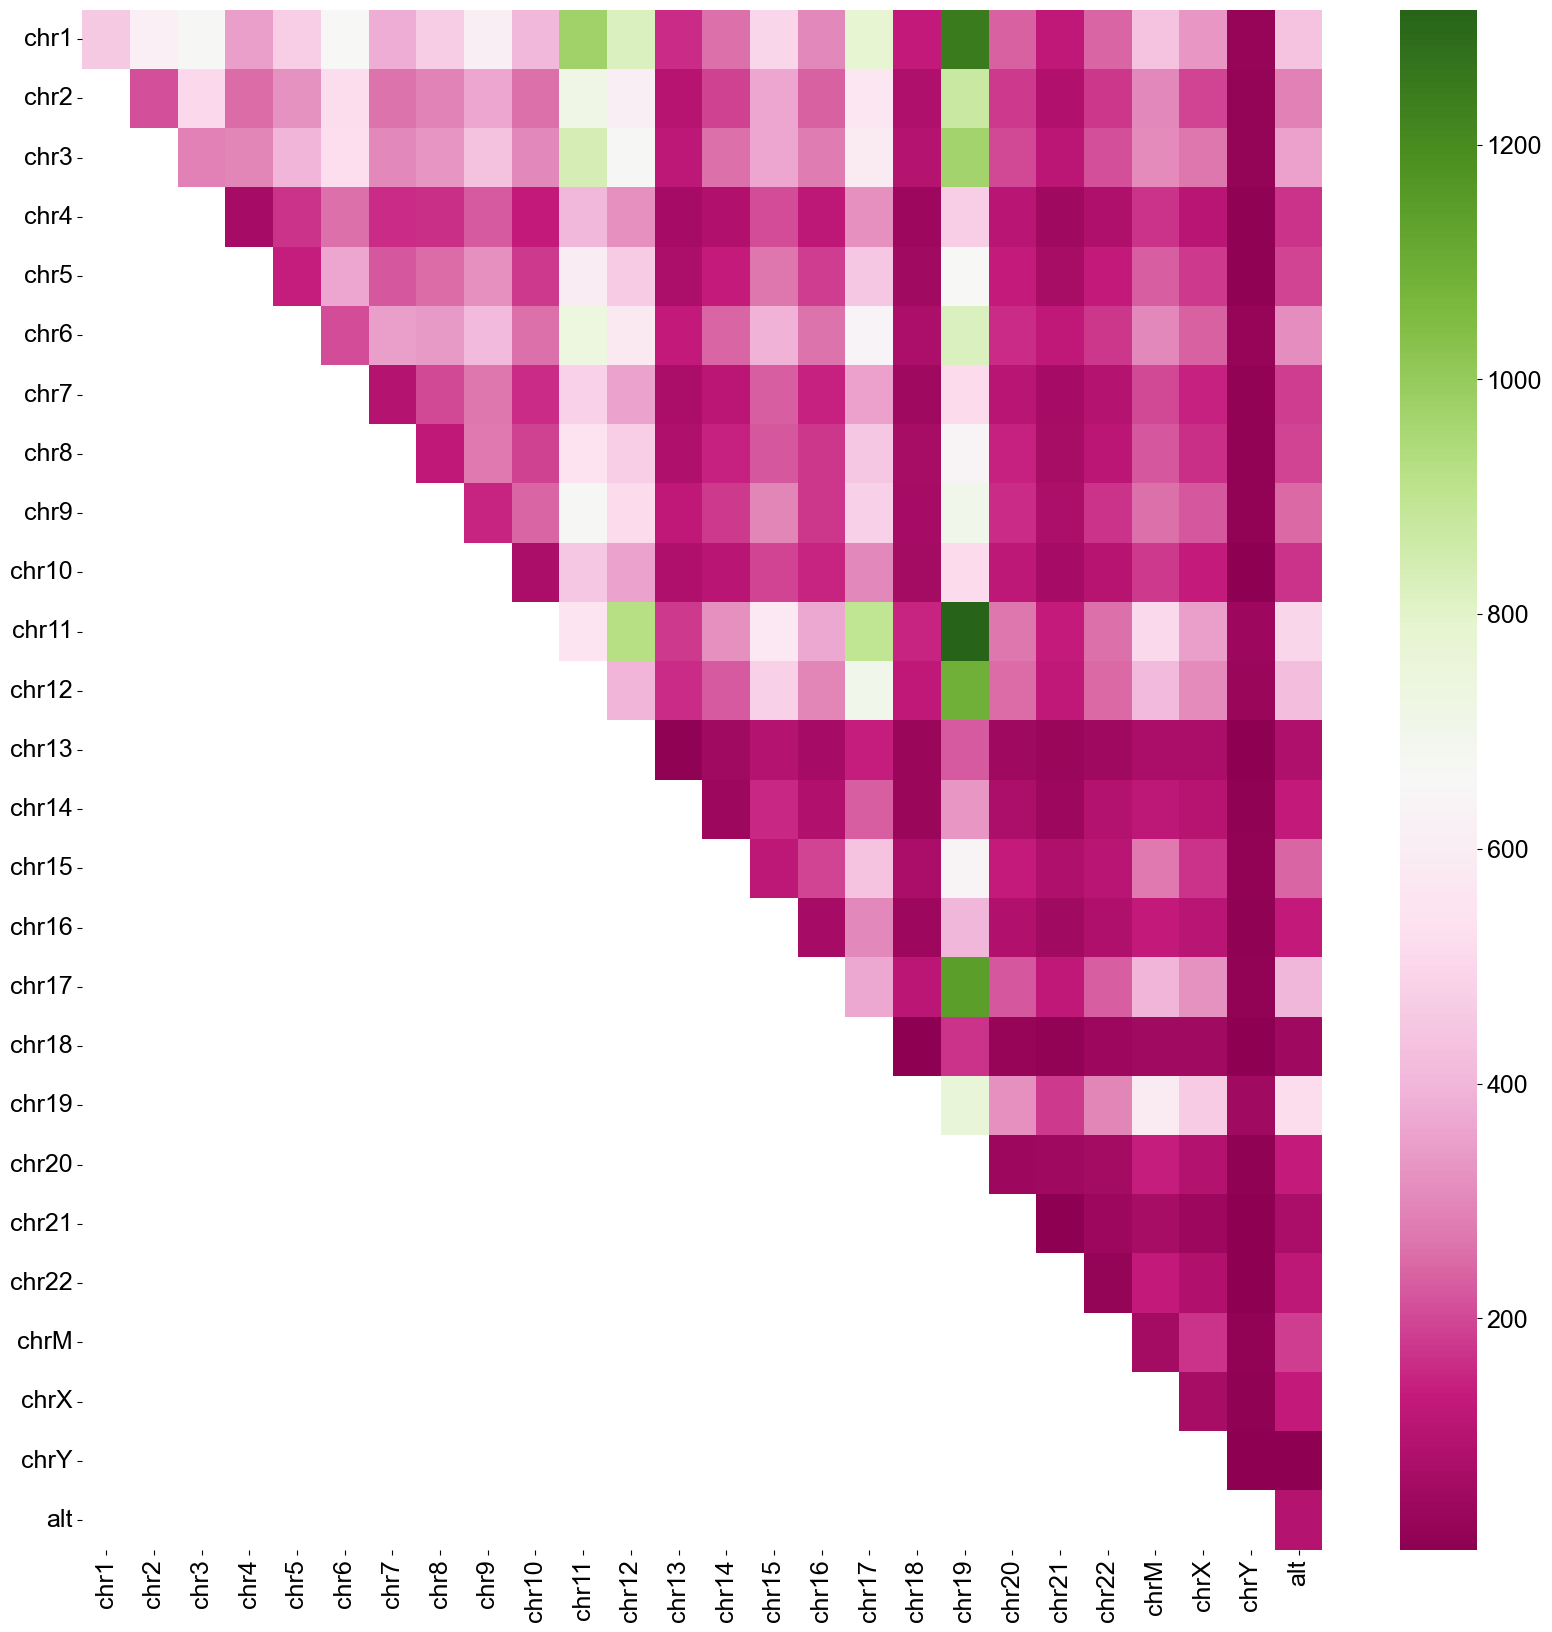

In [59]:
data = matrix_data
fig, ax1 = plt.subplots(figsize=(20, 20))
mask = np.zeros_like(data)
mask[np.tril_indices_from(mask, k=-1)] = True
sns.heatmap(data, mask=mask, cmap="PiYG")

In [149]:
# all_chrs_labels = [f"Chr {i}" for i in range(1, 23)]  + ["Chr M", "Chr X", "Chr Y"]
all_chrs_labels = [f"{i}" for i in range(1, 23)]  + ["M", "X", "Y"]

In [150]:
colors = [ 
"#227980",
"#688F69",
"#D2DC38",
"#F5B16E",
"#F38F3C",
"#CE9FCA",

"#FAE93B",
"#415C42",
"#F7D1E3",
"#734E9C",
"#A9CCDE",
"#707070",

"#8BB8D6",
"#F7BF6C",
"#C0845C",
"#61B673", 
"#F37F76",
"#C3b0D2",

"#D4242A",
"#EE9094",
"#BCD896",
"#C6C2DF",
"#0C0C0C",
"#90D0C2",

"#FFCFD1"
]

all_chrs_colors = {l: colors[ind] for ind, l in enumerate(all_chrs_labels)}

In [151]:
all_chrs_colors

{'1': '#227980',
 '2': '#688F69',
 '3': '#D2DC38',
 '4': '#F5B16E',
 '5': '#F38F3C',
 '6': '#CE9FCA',
 '7': '#FAE93B',
 '8': '#415C42',
 '9': '#F7D1E3',
 '10': '#734E9C',
 '11': '#A9CCDE',
 '12': '#707070',
 '13': '#8BB8D6',
 '14': '#F7BF6C',
 '15': '#C0845C',
 '16': '#61B673',
 '17': '#F37F76',
 '18': '#C3b0D2',
 '19': '#D4242A',
 '20': '#EE9094',
 '21': '#BCD896',
 '22': '#C6C2DF',
 'M': '#0C0C0C',
 'X': '#90D0C2',
 'Y': '#FFCFD1'}

In [152]:
len(colors)

25

In [153]:
# all_chrs_labels
selected_matrix = matrix_data.iloc[:25, :25]
selected_matrix.index = all_chrs_labels 
selected_matrix.columns = all_chrs_labels

In [ ]:
from pycirclize import Circos

# Initialize from matrix (Can also directly load tsv matrix file)
circos = Circos.initialize_from_matrix(
selected_matrix,
    space=1,
    r_lim=(93, 100),
    cmap=all_chrs_colors,
    label_kws=dict(size=16),
    link_kws=dict(ec="black", lw=0, direction=0, alpha=1, color="white"),
)

fig = circos.plotfig(dpi=300, 
# figsize=(10, 10)
)
plt.tight_layout()
fig.savefig("vcap002_sa_tag_summary_connection_chr.pdf", dpi=300)

# Supplemental Figures

## Relative Chop Position

In [11]:
import deepchopper

In [12]:
stats_json_path = "./data/stats_pd1000000_bt0_hy.json"
stats = deepchopper.StatResult.from_json(stats_json_path)

Text(0.5, 0, 'Relative Position')

Text(0, 0.5, 'Density (log scale)')

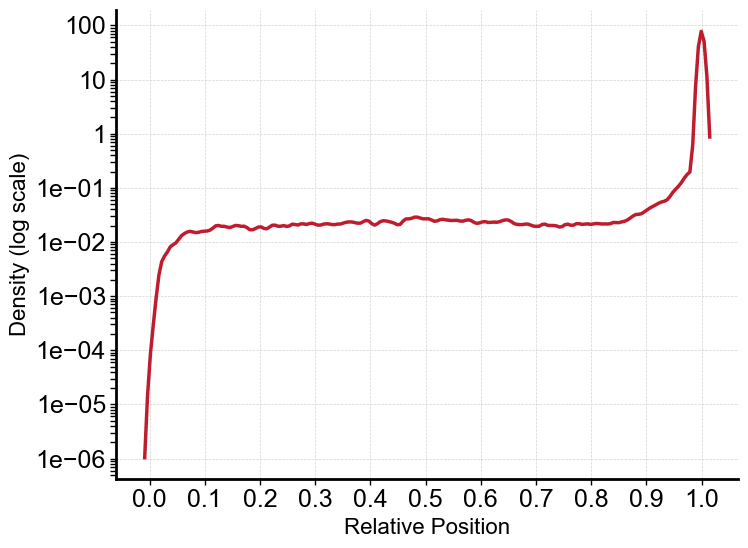

In [13]:
from matplotlib.ticker import LogFormatter

fig, ax = plt.subplots(figsize=(8, 6))

# Create the plot
kde = sns.kdeplot(stats.smooth_intervals_relative_pos, color=d1, linewidth=2.5)

# Set the y-axis to log scale
ax.set_yscale('log')
ax.yaxis.set_major_formatter(LogFormatter())

# Set the x-axis ticks
ax.set_xticks(np.arange(0, 1.1, 0.1))

# Set labels and title
ax.set_xlabel('Relative Position')
ax.set_ylabel('Density (log scale)')

# # Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Set the tick parameters
ax.tick_params(axis='both', which='both', length=4, width=1, direction='out')

# Set the grid
ax.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Adjust the plot layout
plt.tight_layout()

# Save the figure
plt.savefig("relative_chop_pos.pdf", dpi=300)

## Chopped Read Length Distribution

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Density'>

Text(0.5, 0, 'Length of Predicted Artifacts')

Text(0, 0.5, 'Frequency')

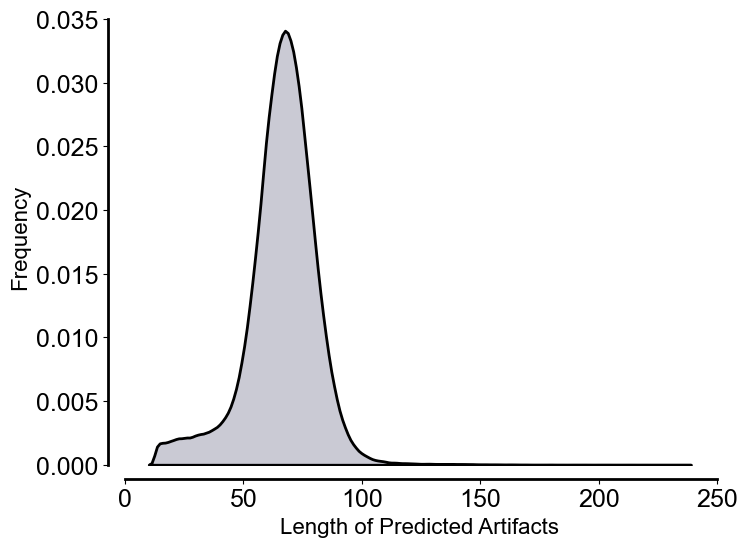

In [14]:
plt.figure(figsize=(8,6))
sns.kdeplot(stats.lenghth_smooth_predicts_with_chop(), fill=True, color=e1, edgecolor="k", linewidth=2)

# plt.xticks(range(0, max_x, 1))
plt.xlabel("Length of Predicted Artifacts")
plt.ylabel("Frequency")

sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("length_of_predicted_artifacts.pdf", dpi=300)

## Chopped Read Count for Read Distribution

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 0, 'The Number of Intervals Per Predict')

Text(0, 0.5, 'Count (Log Scale)')

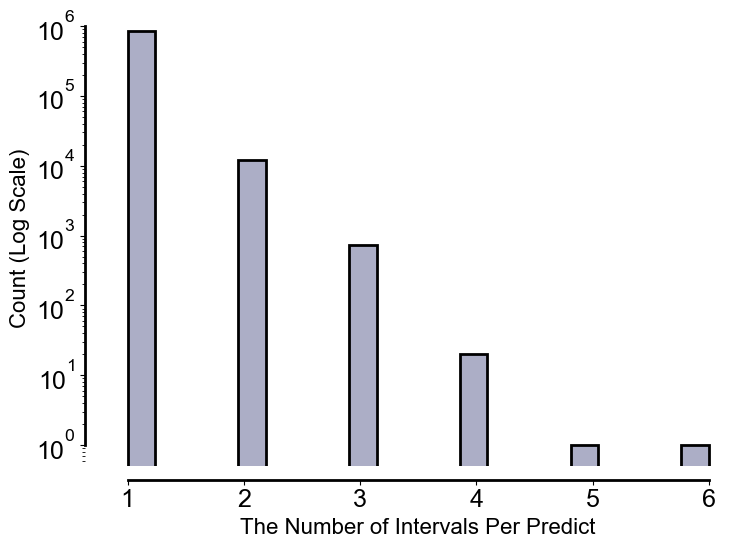

In [15]:
plt.figure(figsize=(8,6))

sns.histplot(stats.number_smooth_predicts_with_chop(), kde=False, color=e2, edgecolor="k", linewidth=2)
# sns.kdeplot(stats.number_smooth_predicts_with_chop(), fill=True, color=e1, edgecolor="k", linewidth=2)

plt.yscale('log')
# plt.xticks(range(0, max_x, 1))

plt.xlabel("The Number of Intervals Per Predict")
plt.ylabel("Count (Log Scale)")

sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("count_of_predicted_artifacts_per_read.pdf", dpi=300)

## Terminal Adapter Base Quality and Blat Results

In [116]:
terminal_adapter_seq_qual = plot_qual("data/vcap_002_hyena_bt0_terminal_adapter.1000000pd.1013638record.chop.fq.gz")

In [117]:
len(terminal_adapter_seq_qual)

847421

<Axes: ylabel='Density'>

Text(0.5, 0, 'Base Qual')

Text(0, 0.5, 'Density')

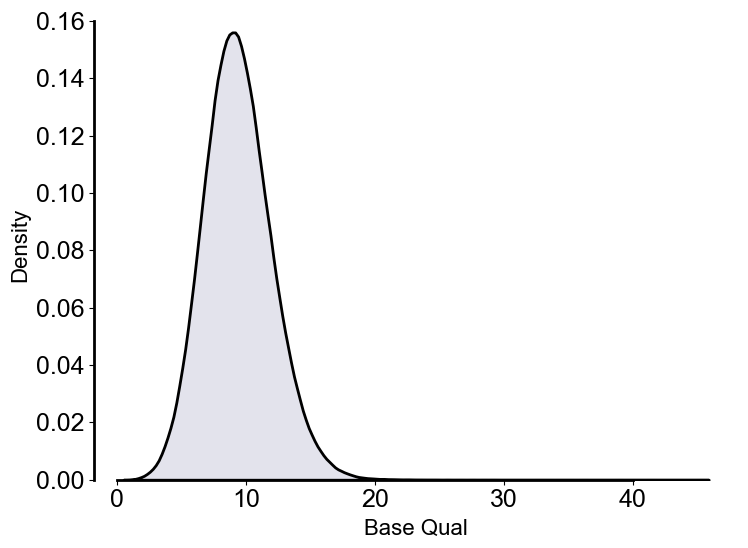

In [152]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=False)
sns.kdeplot(data=terminal_adapter_seq_qual, fill=True, color=e2, edgecolor="k", linewidth=2)

# left_bar = mpatches.Patch(color=e2, label="Removed Sequence")
# right_bar = mpatches.Patch(color=e3, label="Retained Sequence")
# axs[1].legend(handles=[left_bar, right_bar], loc="best")

sns.despine(offset=0, trim=True)

axs.set_xlabel("Base Qual")
plt.ylabel("Density")

plt.tight_layout()

plt.savefig(
    "base_quals_for_terminal_adapter_vcap_bt0.pdf",
    bbox_inches="tight",
    dpi=300,
)

In [118]:
terminal_adapter_blat = json.load(open("data/terminal_adapter_blat.json"))

<Axes: ylabel='Density'>

Text(0.5, 0, 'BLAT Indentity')

Text(0, 0.5, 'Density')

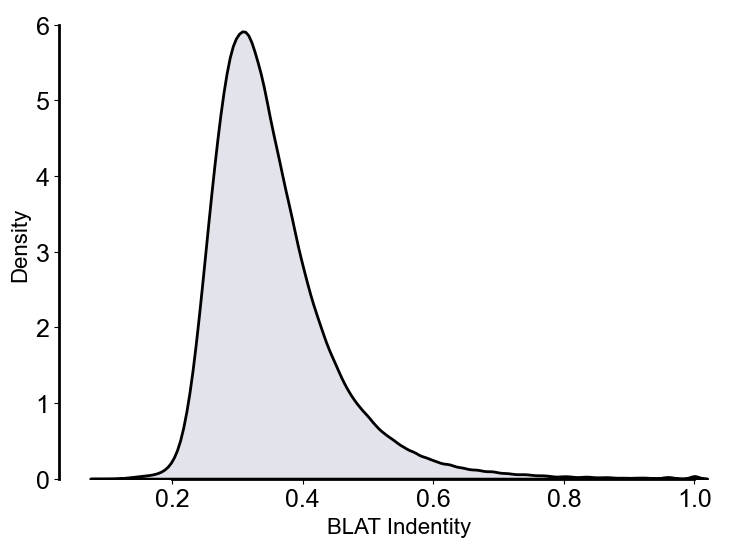

In [154]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=False)
sns.kdeplot(data=terminal_adapter_blat, fill=True, color=e2, edgecolor="k", linewidth=2)

# left_bar = mpatches.Patch(color=e2, label="Removed Sequence")
# right_bar = mpatches.Patch(color=e3, label="Retained Sequence")
# axs[1].legend(handles=[left_bar, right_bar], loc="best")

sns.despine(offset=0, trim=True)
axs.set_xlabel("BLAT Indentity")
plt.ylabel("Density")

plt.tight_layout()

plt.savefig(
    "blat_indentity_for_terminal_adapter_vcap_bt0.pdf",
    bbox_inches="tight",
    dpi=300,
)

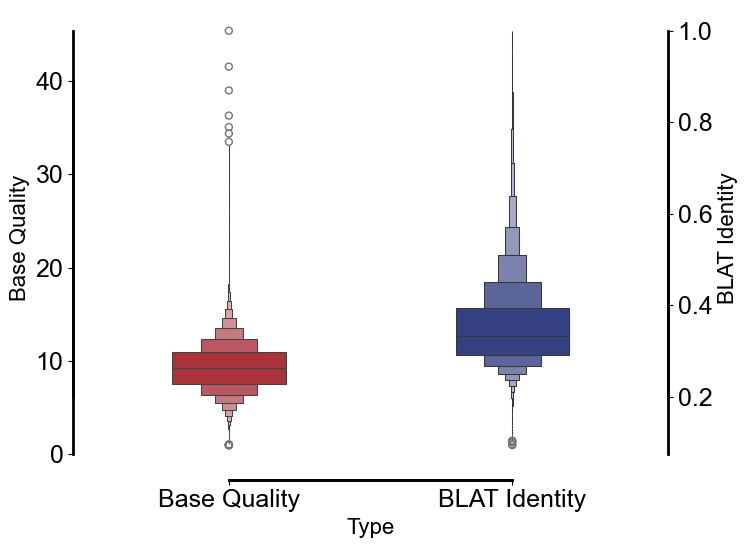

In [119]:
plot_box_for_base_qual_and_blat(terminal_adapter_seq_qual, terminal_adapter_blat, plot_type="boxenplot",figname="vcap002_terminal_base_qual_and_blat_box_plot.pdf")

## Terminal Adapter Chop Compared with SoftClipping of Bam

In [2]:
pie_data = {
"SC": 603299,
"NOSC" : 2144,
"NoBLAT": 2075,
}

[Text(0, 0, '3%')]

[Text(0, 0, '97%')]

(-0.11000000000000001, 0.11000000000000001, 0.0, 1.05)

(-0.5, 0.5)

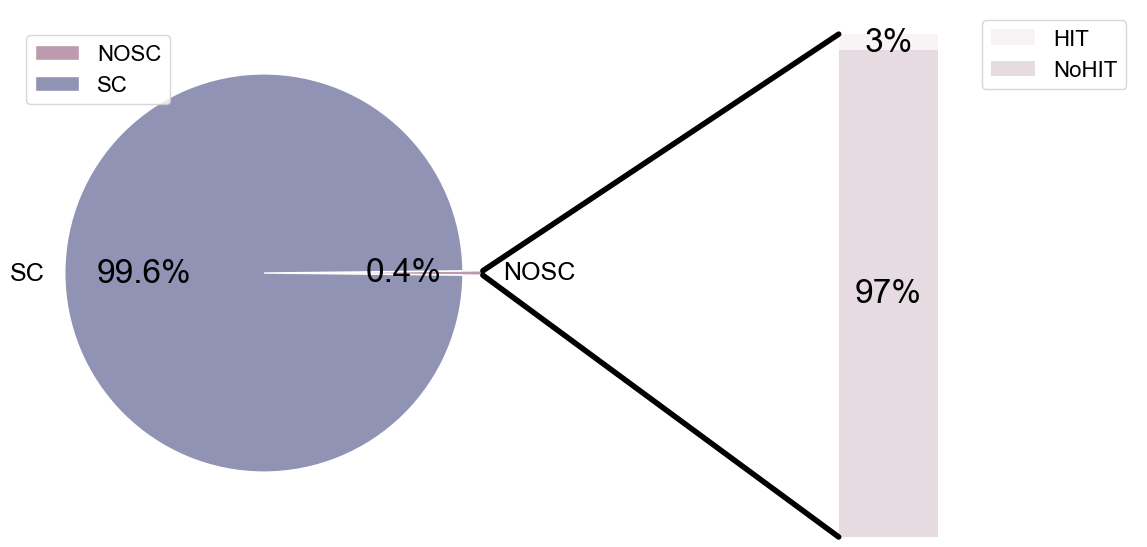

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [pie_data['NOSC']/sum(pie_data.values()),  pie_data['SC'] /sum(pie_data.values()) ]
labels = ['NOSC', 'SC']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode, 
                     colors=[e3, e2],
                     wedgeprops={"linewidth": 1, "edgecolor": "white"}
                     )

# bar chart parameters
age_ratios = [pie_data['NoBLAT']/ pie_data['NOSC'], (pie_data['NOSC'] - pie_data['NoBLAT'])/ pie_data['NOSC']]
age_labels = ['NoHIT', 'HIT']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color=e3, label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

# ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

# add a lengend for the pie chart
ax1.legend(wedges, labels,
        #    title="Chimeric Artifacts",
           loc="upper left")

plt.tight_layout()
plt.savefig("pie_bar_chart.pdf", dpi=300)

1